Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [6]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train")
data_dir_test = pathlib.Path("/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Test")


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-11-19 19:31:28.973816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2024-11-19 19:31:28.973972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2024-11-19 19:31:28.978125: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


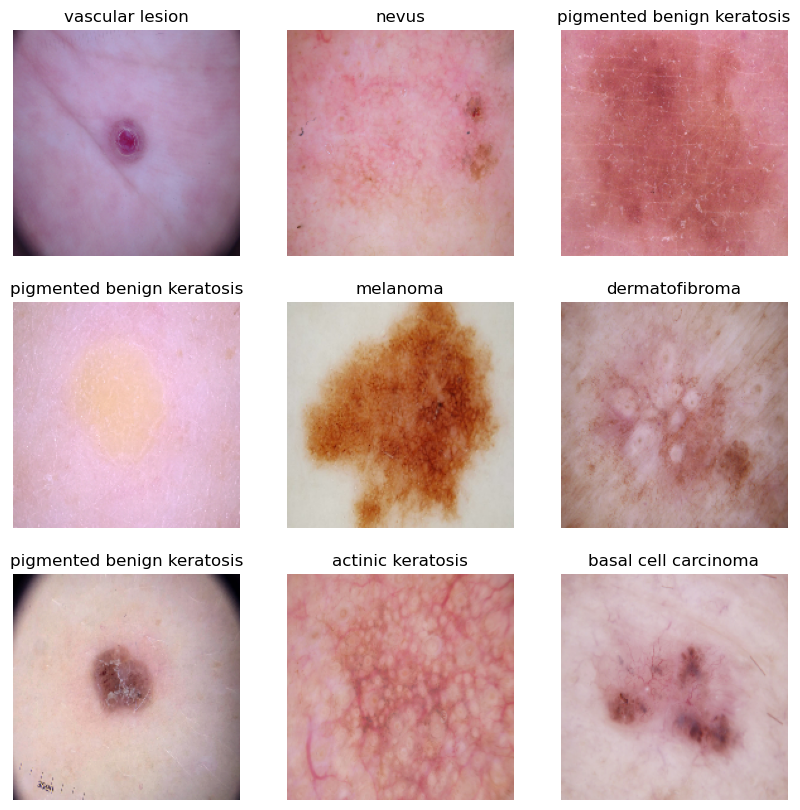

In [18]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [20]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [24]:
### Your code goes here

from tensorflow.keras.layers import Rescaling

# Normalize pixel values using Rescaling
normalization_layer = Rescaling(1./255)

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [25]:
# Check the datasets
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Pixel value range: min={tf.reduce_min(images).numpy()}, max={tf.reduce_max(images).numpy()}")

2024-11-19 19:31:30.231058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2024-11-19 19:31:30.231257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]


Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)
Pixel value range: min=0.0, max=255.0


In [26]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [28]:
### Todo, choose an appropirate optimiser and loss function
#model.compile(optimizer='your_optimser',
#              loss=your_loss_function_goes_here,
#              metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-11-19 19:31:33.822740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2024-11-19 19:31:33.822952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 2.0648 - accuracy: 0.1959

2024-11-19 19:31:47.829639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]
2024-11-19 19:31:47.829808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 16s 280ms/step - loss: 2.0648 - accuracy: 0.1959 - val_loss: 2.0035 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 15s 270ms/step - loss: 1.8282 - accuracy: 0.3214 - val_loss: 1.7071 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 15s 273ms/step - loss: 1.5575 - accuracy: 0.4431 - val_loss: 1.6187 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 15s 262ms/step - loss: 1.4875 - accuracy: 0.4743 - val_loss: 1.4254 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 15s 264ms/step - loss: 1.4108 - accuracy: 0.5017 - val_loss: 1.4398 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 14s 259ms/step - loss: 1.3500 - accuracy: 0.5318 - val_loss: 1.5179 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 16s 279ms/step - loss: 1.2879 - accuracy: 0.5530 - val_loss: 1.4868 - val_accuracy: 0.5034
Epoch 8/20

### Visualizing training results

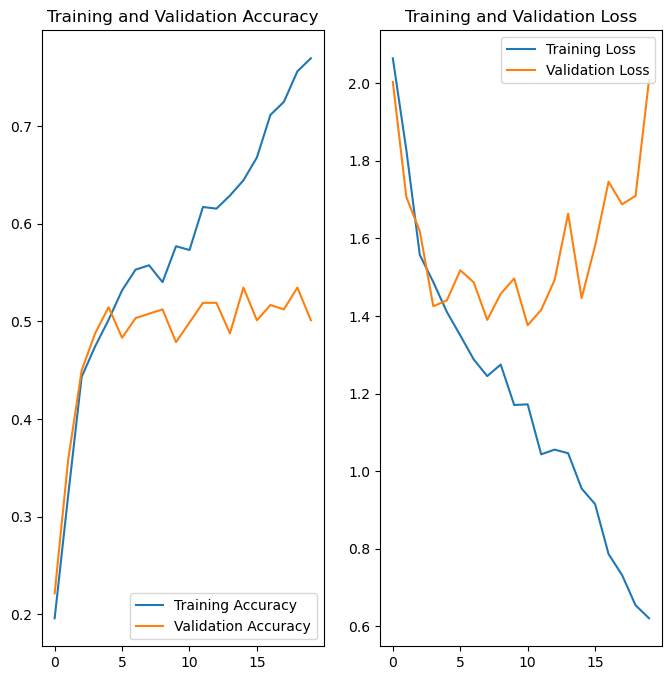

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## Findings from Model Fit History

**Training Loss and Accuracy:**
The training accuracy steadily increased, reaching around 76.23% by the 20th epoch.
The training loss decreased consistently, indicating the model is learning from the training data.

**Validation Loss and Accuracy:**
The validation accuracy peaked around 53.47%, but it fluctuates and does not improve further.
The validation loss starts decreasing at first and after few epochs it started increasing again.
Signs of Overfitting:

The gap between training and validation accuracy widens over time.
The validation loss increases while the training loss decreases.
The training accuracy is high (76%), but validation accuracy is relatively lower (50-53%).

**Evidence of Overfitting**
This behavior indicates that the model is overfitting the training data, as it performs well on the training set but does not generalize to the validation set.



In [37]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_augmented = data_augmentation.flow_from_directory(
    data_dir_train,  # Replace with your training directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)


Found 2239 images belonging to 9 classes.


In [38]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes herfrom tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Create the model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Add dropout if overfitting is detected
    layers.Dense(9, activation='softmax')  # Assuming 9 classes
])




### Compiling the model

In [42]:
## Your code goes here

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 128)      

### Training the model

In [44]:
## Your code goes here, note: train your model for 20 epochs
# Early stopping callback

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [45]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
56/56 [==============================] - 18s 315ms/step - loss: 2.0516 - accuracy: 0.2081 - val_loss: 1.9295 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 16s 284ms/step - loss: 1.9163 - accuracy: 0.2874 - val_loss: 1.7381 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 15s 272ms/step - loss: 1.6970 - accuracy: 0.3850 - val_loss: 1.6127 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 16s 281ms/step - loss: 1.7146 - accuracy: 0.3811 - val_loss: 1.6447 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 15s 273ms/step - loss: 1.5506 - accuracy: 0.4397 - val_loss: 1.4759 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 17s 313ms/step - loss: 1.4672 - accuracy: 0.4693 - val_loss: 1.5234 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 16s 277ms/step - loss: 1.4971 - accuracy: 0.4699 - val_loss: 1.4193 - val_accuracy: 0.4989

### Visualizing the results

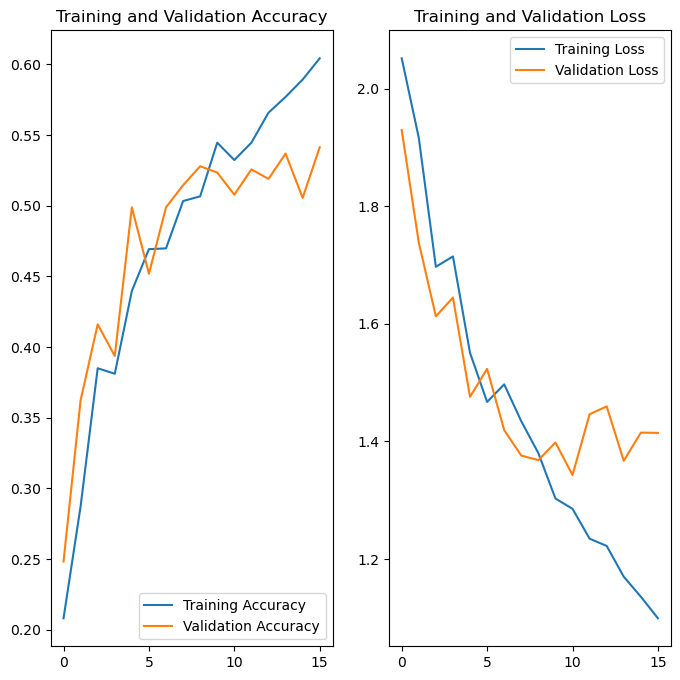

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## Findings After Model Training:

**Training vs Validation Loss and Accuracy Trends:**

The training loss steadily decreases across epochs, showing the model is learning from the training data.
The validation loss initially decreases but fluctuates in later epochs, indicating a potential start of overfitting around epochs 13-15.
Validation accuracy does not show significant improvement after epoch 10, with minor fluctuations observed.

**Comparison to Previous Model:**
The new model exhibits better control of validation loss compared to the previous run. In the earlier model, validation loss increased sharply in later epochs, signaling clear overfitting. The dropout layer and early stopping seem to have mitigated this issue partially.
Validation accuracy has a slight improvement, stabilizing around 52-53%, as compared to the previous run where it hovered around 50%.
Training accuracy is higher (60.44%) than validation accuracy (54.14%), which could indicate mild overfitting but with some generalization improvements.

**Evidence of Overfitting or Underfitting:**

**Overfitting:** The gap between training and validation accuracy (around 6%) and the plateauing validation performance after epoch 10 suggest mild overfitting.
**Underfitting:** Validation accuracy plateauing around 53% indicates that the model may not yet fully capture the underlying data patterns.
Improvements:

The addition of the dropout layer has helped reduce severe overfitting observed in the previous model.
Early stopping prevented the model from training unnecessarily after the validation performance stabilized, saving training time and improving the generalization capability.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class Distribution in Training Data:
nevus: 277
melanoma: 352
vascular lesion: 115
actinic keratosis: 92
basal cell carcinoma: 309
pigmented benign keratosis: 370
squamous cell carcinoma: 142
seborrheic keratosis: 58
dermatofibroma: 77


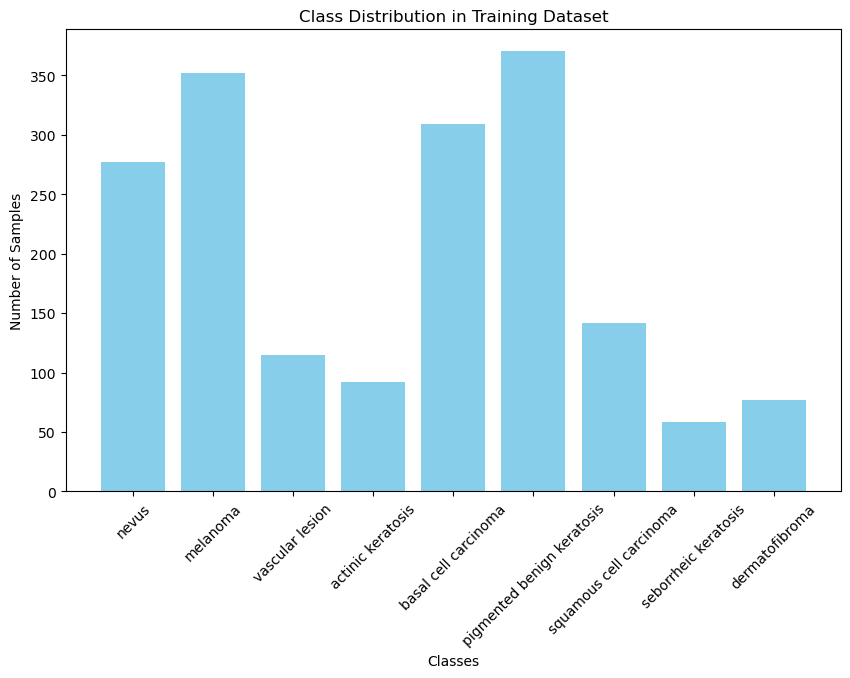

In [51]:
## Your code goes here.

# Assuming `train_ds` is the training dataset
from collections import Counter
import matplotlib.pyplot as plt

# Extract class names and map indices to names
#class_names = train_ds.class_names

# Flatten the labels to count occurrences
labels = []
for _, batch_labels in train_ds:
    labels.extend(batch_labels.numpy())

# Count occurrences of each class
class_counts = Counter(labels)
class_distribution = {class_names[k]: v for k, v in class_counts.items()}

# Print the distribution of classes
print("Class Distribution in Training Data:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Findings:
Class with the Least Number of Samples:

The class with the least number of samples is seborrheic keratosis, with only 58 samples.
Classes Dominating the Data:

The classes with the highest number of samples are:
pigmented benign keratosis: 370 samples
melanoma: 352 samples
basal cell carcinoma: 309 samples
These three classes dominate the dataset in terms of the proportionate number of samples.
Observations:
There is a noticeable class imbalance in the dataset, with seborrheic keratosis and dermatofibroma being underrepresented compared to other classes like pigmented benign keratosis and melanoma.
This imbalance can potentially lead to the model performing poorly on underrepresented classes, as it might not learn enough distinguishing features for them.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [55]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [57]:
# #path_to_training_dataset = "/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
# path_to_training_dataset = data_dir_train
#import Augmentor
# for i in class_names:
#    p = Augmentor.Pipeline(path_to_training_dataset + i)
#    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


import Augmentor
path_to_training_dataset = data_dir_train
# Iterate over class names and augment the data
for class_name in class_names:
    class_path = path_to_training_dataset / class_name  # Use '/' to concatenate paths correctly
    if class_path.exists():  # Ensure the class directory exists
        p = Augmentor.Pipeline(str(class_path))  # Convert the Path object to string for Augmentor
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)  # Rotation augmentation
        p.sample(500)  # Add 500 augmented samples per class
    else:
        print(f"Directory does not exist: {class_path}")


Initialised with 114 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x307991F10>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 286.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30690B1D0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 306.23 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x306843650>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x306A51E90>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x306A21990>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 89.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3079049D0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 357.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x306908150>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 153.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x306A0A650>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 330.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3069CFED0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 356.61 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [59]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_e7093812-436f-4b03-924c-6524360042f1.jpg',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_5bb4b3ea-0b49-4155-a12c-77152f636c04.jpg',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0001157.jpg_c0c91649-aadb-4d04-9e9a-29c5463fd6d5.jpg',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_9066e679-1162-40b2-a589-46b62d45dd5c.jpg',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The Int

In [62]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [63]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Create a dictionary mapping the image paths to lesion types
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

# Check the result
dataframe_dict_new

{'/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_e7093812-436f-4b03-924c-6524360042f1.jpg': 'melanoma',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_5bb4b3ea-0b49-4155-a12c-77152f636c04.jpg': 'melanoma',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0001157.jpg_c0c91649-aadb-4d04-9e9a-29c5463fd6d5.jpg': 'melanoma',
 '/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_9066e679-1162-40b2-a589-46b62d45dd5c.jpg': 'melanoma',
 '/Users/vijaymallepudi/Downloads/Melano

In [64]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [65]:
print(new_df.head())

                                                Path     Label
0  /Users/vijaymallepudi/Downloads/Melanoma Detec...  melanoma
1  /Users/vijaymallepudi/Downloads/Melanoma Detec...  melanoma
2  /Users/vijaymallepudi/Downloads/Melanoma Detec...  melanoma
3  /Users/vijaymallepudi/Downloads/Melanoma Detec...  melanoma
4  /Users/vijaymallepudi/Downloads/Melanoma Detec...  melanoma


In [66]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [71]:
#data_dir_train="/Users/vijaymallepudi/Downloads/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [75]:
## your code goes here

# Normalize pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Apply the normalization to the dataset
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance
# train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# # Define the model
# model = models.Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]
    
#     # Conv2D layers: Extract features using convolution
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),

#     # Flatten the 3D feature maps to 1D vector for fully connected layers
#     layers.Flatten(),

#     # Fully connected (dense) layer
#     layers.Dense(128, activation='relu'),

#     # Dropout layer to prevent overfitting
#     layers.Dropout(0.5),

#     # Output layer with softmax for multi-class classification
#     layers.Dense(10, activation='softmax')  # 10 classes (adjust as per your classes)
# ])



# # Create the model
# model = models.Sequential([
#     # Input layer with normalization
#     #Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalizes pixel values to [0, 1]
    
#     # Convolutional layers
#     layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'),
#     layers.MaxPooling2D((2, 2)),
    
#     # Flatten and Dense layers
#     layers.Flatten(),
#     layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
#     layers.Dropout(0.5),  # Prevent overfitting
#     layers.Dense(9, activation='softmax')  # Output layer for 9 classes
# ])


#Sequential allows you to create models layer-by-layer  
model = Sequential()

#model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))),  # Normalize pixel values to [0, 1]

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(9,activation='softmax'))



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [77]:
# ## your code goes here
# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
#               metrics=['accuracy'])




#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)

In [78]:
# Print model summary
model.build(input_shape=(32, 180, 180, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:**  Train your model

In [80]:
epochs = 30
## Your code goes here, use 50 epochs.
#history = # your model fit code


# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# # Train the model
# history = model.fit(
#     train_ds,  # The training dataset
#     epochs=epochs,  # Number of epochs
#     validation_data=val_ds,  # Use validation data for validation
#     verbose=2,  # Display progress during training
#     callbacks=[early_stopping]
# )


history = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=epochs,
        callbacks=[checkpoint,earlystop]
)

Epoch 1/30


2024-11-19 19:41:08.485692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]
2024-11-19 19:41:08.485889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]


169/169 [==============================] - ETA: 0s - loss: 1.9021 - accuracy: 0.2743

2024-11-19 19:41:57.831518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]
2024-11-19 19:41:57.831707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1347]
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.43133, saving model to model.h5
169/169 [==============================] - 54s 269ms/step - loss: 1.9021 - accuracy: 0.2743 - val_loss: 1.5018 - val_accuracy: 0.4313
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5431 - accuracy: 0.4178
Epoch 2: val_accuracy improved from 0.43133 to 0.48330, saving model to model.h5
169/169 [==============================] - 43s 257ms/step - loss: 1.5431 - accuracy: 0.4178 - val_loss: 1.3621 - val_accuracy: 0.4833
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4577 - accuracy: 0.4549
Epoch 3: val_accuracy improved from 0.48330 to 0.52932, saving model to model.h5
169/169 [==============================] - 45s 269ms/step - loss: 1.4577 - accuracy: 0.4549 - val_loss: 1.2975 - val_accuracy: 0.5293
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.3315 - accuracy: 0.5017
Epoch 4: val_accuracy improved from 0.52932 to 0.57090, saving model 

#### **Todo:**  Visualize the model results

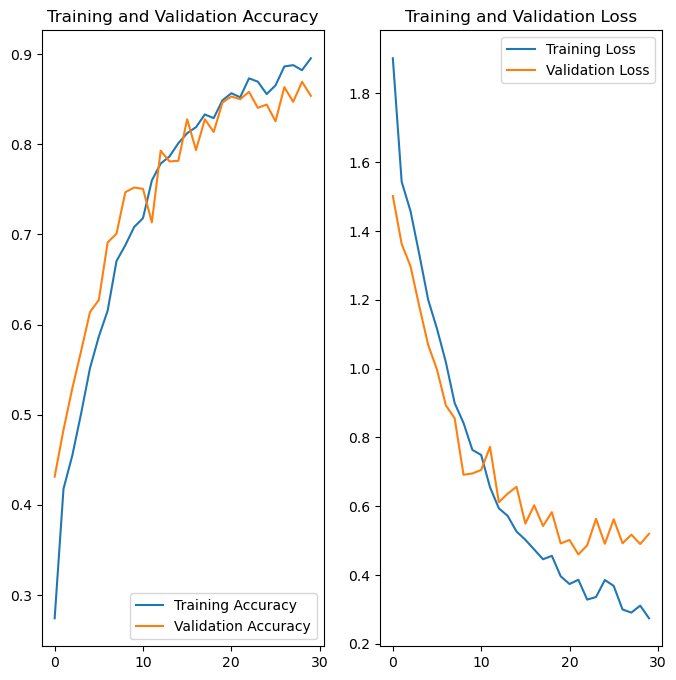

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Observations:

**Accuracy Improvement:**
Training accuracy started at 27.43% (Epoch 1) and steadily improved to 89.54% (Epoch 30).
Validation accuracy started at 43.13% and reached a peak of 86.93% in Epoch 29, with a slight decline in the final epoch.

**Loss Metrics:**
Training loss decreased consistently from 1.90 to 0.27, showing that the model learned effectively during training.
Validation loss followed a similar pattern, but there were some fluctuations. Validation loss hovered around 0.51. 

**Overfitting or Underfitting:**
The gap between training accuracy and validation accuracy remained small throughout, indicating minimal overfitting.
Training and validation losses did not diverge significantly, confirming the absence of overfitting.
The model's steady improvement in both metrics suggests no underfitting.

**Impact of Class Rebalancing:**
Aftaer class rebalancing was applied (e.g., via data augmentation), the improvement in both accuracy and balanced validation metrics suggests it helped the model better generalize across imbalanced classes.